In [9]:
import os
import sys
module_path = os.path.abspath('/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis')
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from functions import chrysalis_plot, plot_component, chrysalis_svg, chrysalis_pca, chrysalis_aa, \
    generate_random_colors, plot_explained_variance, compartment_heatmap, get_compartment_df, plot_svgs, color_similarity_nh, plot_weights

In [3]:
data_path = module_path + '/data/benchmarks/cluster/Human_Breast_Cancer/'
save_path = module_path + '/data/processed/V1_Breast_Cancer_Block_A_Section_1.h5ad'

Read Visium data and add manual annotations to a column in `.obs`.

In [4]:
adata = sc.datasets.visium_sge(sample_id='V1_Breast_Cancer_Block_A_Section_1')

# add metadata and remove nan spots
df_meta = pd.read_csv(data_path + 'data/metadata.tsv', sep='\t')
adata.obs['ground_truth'] = df_meta['ground_truth'].values
adata = adata[~adata.obs['ground_truth'].isna()]
adata.obs['ground_truth'] = adata.obs['ground_truth'].astype('category')

First we detect spatially variable genes using Moran's I. `chrysalis_svg` calculates Moran's I for every gene that is expressed in at least 10% of the capture spots. This can be tuned by setting the `min_spots` parameter.

By default, either the top 1000 genes will be marked as spatially variable or if less genes are above the minimal Moran's I threshold, then only those will be selected. This can also be set manually with the `min_morans` parameter.

In [5]:
chrysalis_svg(adata)
adata.write_h5ad(save_path)

Calculating SVGs: 100%|██████████| 11993/11993 [02:41<00:00, 74.06it/s]


Looking at the calculated Moran's I values for the examined genes, we can determine if the default selection parameter was sufficient. In this case the inflection point is around 0.2, so there is no need to set a new threshold.

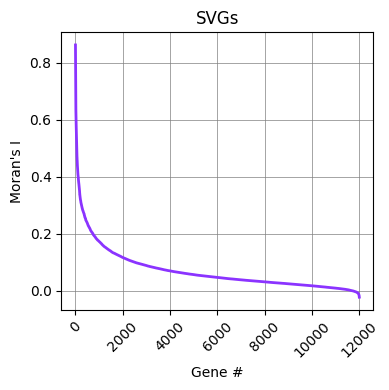

In [6]:
plot_svgs(adata)

We can modify the number of SVGs by setting a different threshold and replacing the `spatially_variable` column with the new selection.

```python
moran_df = adata.var[adata.var["Moran's I"] > 0.2]
adata.var['spatially_variable'] = [True if x in moran_df.index else False for x in adata.var_names]
```

Next step is to run `chrysalis_pca` on the SVGs. Here we transform the count matrix with `scanpy`'s normalization and log transform functions, but alternative methods can also be used.

In [4]:
adata = sc.read_h5ad(save_path)

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

chrysalis_pca(adata, n_pcs=50)

By looking at the cumulative explained variance plot we can select the number of PCs to be used for inferring the tissue compartments. If too many PCs are selected, less biologically relevant components may be found.

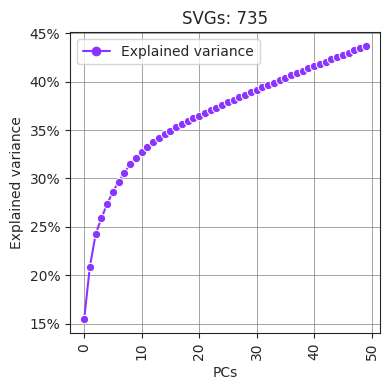

In [5]:
plot_explained_variance(adata)

`chrysalis_aa` infers tissue compartments. We can define the number of input PCs, and the number of tissue compartments to be found. `chrysalis_plot` is used to visualize the results.

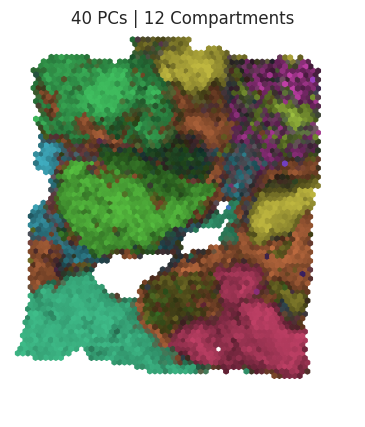

In [7]:
chrysalis_aa(adata, n_pcs=40, n_archetypes=12)

chrysalis_plot(adata, dim=12)
plt.title('40 PCs | 12 Compartments')
plt.show()

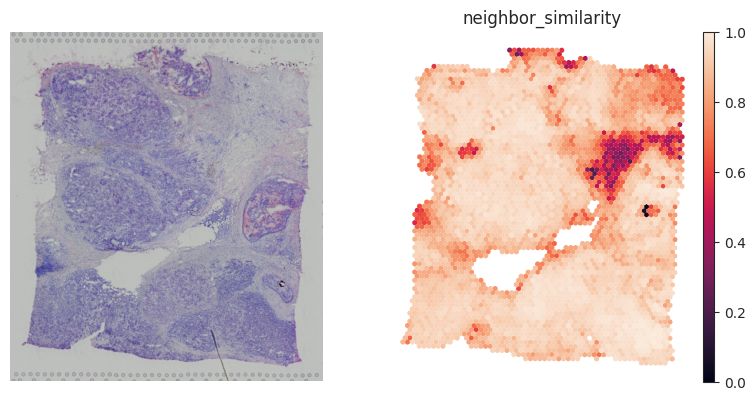

In [17]:
cos_ar_nh = color_similarity_nh(adata, nh=6, mode='cos_sim')
adata.obsm['chr_X_pca'] = adata.obsm['chr_X_pca'] * cos_ar_nh
adata.obs['neighbor_similarity'] = cos_ar_nh

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, frameon=False, alpha_img=1.0,
              ax=ax[0], show=False)
sc.pl.spatial(adata, color='neighbor_similarity', size=1.7, frameon=False, alpha_img=0.0, cmap='rocket',
              ax=ax[1], show=False)
plt.tight_layout()
plt.show()

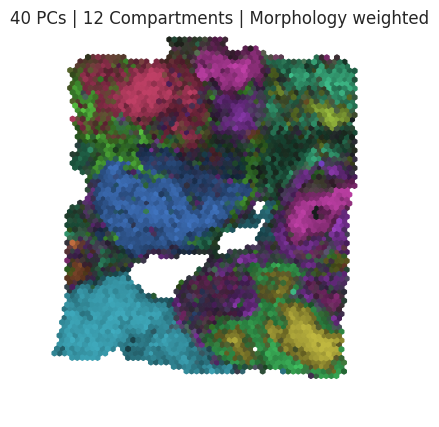

In [14]:
chrysalis_aa(adata, n_pcs=40, n_archetypes=12)

chrysalis_plot(adata, dim=12)
plt.title('40 PCs | 12 Compartments | Morphology weighted')
plt.show()

To visualize the compartments individually, we are generating a `matplotlib` figure and use `plot_componet` to draw subplots.

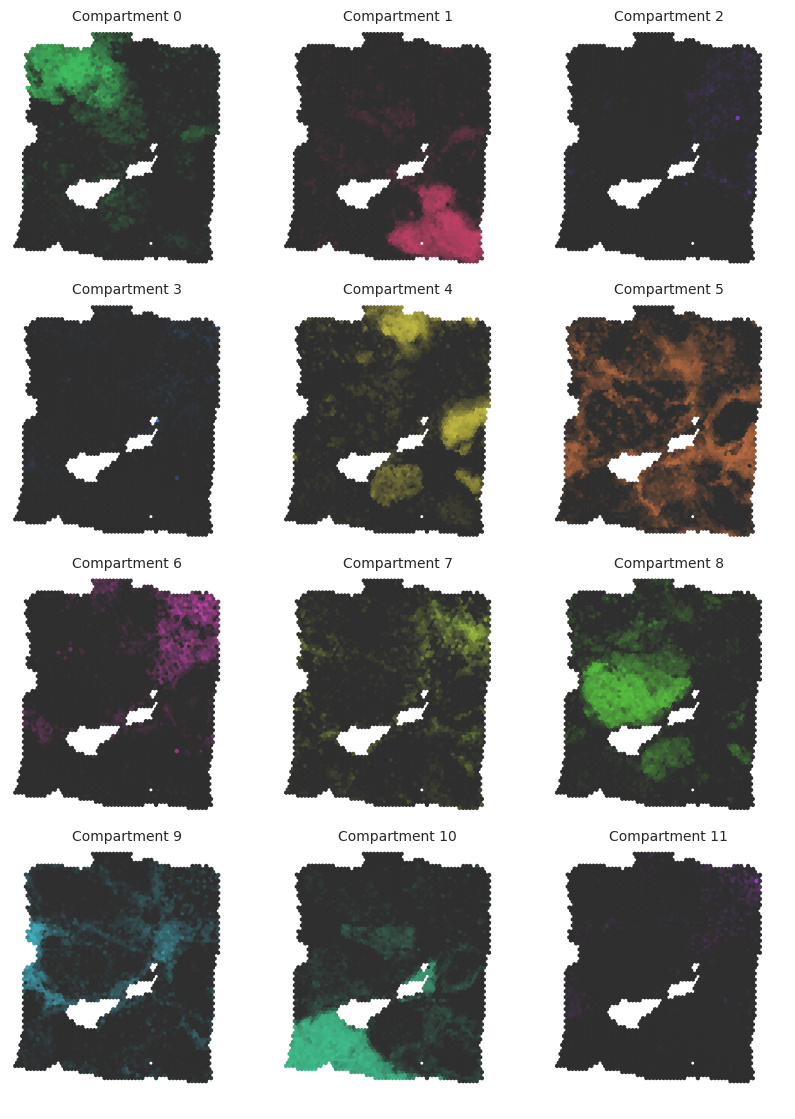

In [10]:
hexcodes = generate_random_colors(num_colors=12, min_distance=1 / 12 * 0.5)
fig, axs = plt.subplots(4, 3, figsize=(15*0.6, 20*0.6))
axs = axs.flatten()
plt.subplots_adjust(hspace=0.05, wspace=0.01, left=0.05, right=0.95, top=0.95, bottom=0.05)
for i, ax in enumerate(axs):
    plot_component(adata, fig, ax, hexcodes=hexcodes, dim=12, selected_dim=i, color_first='#2e2e2e', spot_size=0.85)
    ax.set_title(f'Compartment {i}', size=10)
plt.show()

Gene expression signatures corresponding to the individual compartments can also be calculated. Genes with positive values are upregulated, and genes with negative values are downregulated in specific compartments.

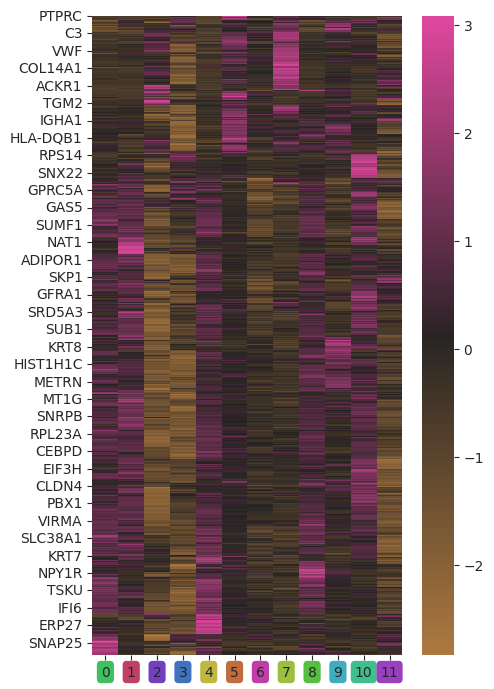

In [8]:
compartment_heatmap(adata)

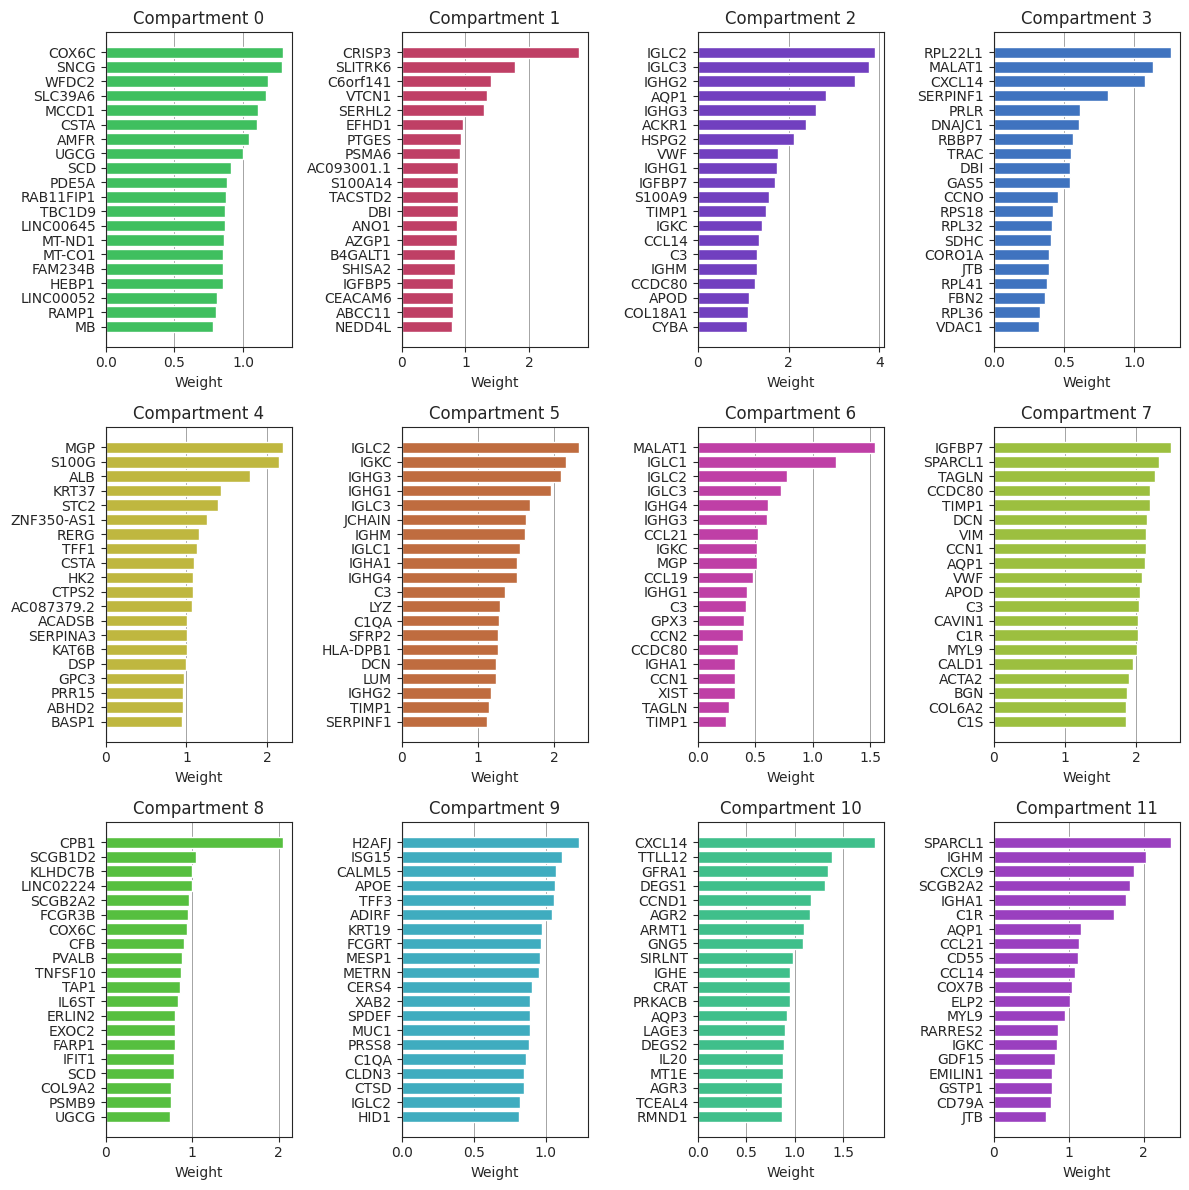

In [10]:
plot_weights(adata)

Finally, we can retrieve the expression for the individual genes as a dataframe.

In [12]:
comp_df = get_compartment_df(adata)
print(comp_df.head())

       compartment_0  compartment_1  compartment_2  compartment_3  \
ISG15       3.043789       3.245794       1.116969       1.612503   
SRARP       1.873059       1.574837       0.527695       1.600338   
HSPG2       0.600951       0.845509       3.331760       0.807484   
C1QA        1.251673       1.214888       0.479502      -0.210869   
C1QC        0.943989       0.956841       0.224709      -1.166789   

       compartment_4  compartment_5  compartment_6  compartment_7  \
ISG15       3.184495       3.304320       3.170880       2.735719   
SRARP       1.778461       1.050123       0.602635       0.438632   
HSPG2       0.626909       1.676641       0.673563       2.668125   
C1QA        0.864204       3.185907       1.973797       2.491233   
C1QC        0.461111       2.221570       0.449877       1.301426   

       compartment_8  compartment_9  compartment_10  compartment_11  
ISG15       3.636841       4.413113        2.917268        2.986048  
SRARP       1.986299       1.7